## To do:
 * Build custom transformers to push the data through the preprocessing pipeline
 * Split the data into training and test sets 
 * Perform a grid search and choose best models using CV
 * Compare models

In [31]:
import pandas as pd
import numpy as np
import warnings
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import FeatureUnion, Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from matplotlib import pyplot as plt

warnings.filterwarnings('ignore')
%matplotlib inline

In [10]:
# load the data
data = pd.read_csv('C:/Users/mateu/PYTHON/Datasets/UCI_Credit_Card.csv')

data.describe()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default.payment.next.month
count,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,...,30000.000000,30000.000000,30000.000000,30000.000000,3.000000e+04,30000.00000,30000.000000,30000.000000,30000.000000,30000.000000
mean,15000.500000,167484.322667,1.603733,1.853133,1.551867,35.485500,-0.016700,-0.133767,-0.166200,-0.220667,...,43262.948967,40311.400967,38871.760400,5663.580500,5.921163e+03,5225.68150,4826.076867,4799.387633,5215.502567,0.221200
std,8660.398374,129747.661567,0.489129,0.790349,0.521970,9.217904,1.123802,1.197186,1.196868,1.169139,...,64332.856134,60797.155770,59554.107537,16563.280354,2.304087e+04,17606.96147,15666.159744,15278.305679,17777.465775,0.415062
min,1.000000,10000.000000,1.000000,0.000000,0.000000,21.000000,-2.000000,-2.000000,-2.000000,-2.000000,...,-170000.000000,-81334.000000,-339603.000000,0.000000,0.000000e+00,0.00000,0.000000,0.000000,0.000000,0.000000
25%,7500.750000,50000.000000,1.000000,1.000000,1.000000,28.000000,-1.000000,-1.000000,-1.000000,-1.000000,...,2326.750000,1763.000000,1256.000000,1000.000000,8.330000e+02,390.00000,296.000000,252.500000,117.750000,0.000000
50%,15000.500000,140000.000000,2.000000,2.000000,2.000000,34.000000,0.000000,0.000000,0.000000,0.000000,...,19052.000000,18104.500000,17071.000000,2100.000000,2.009000e+03,1800.00000,1500.000000,1500.000000,1500.000000,0.000000
75%,22500.250000,240000.000000,2.000000,2.000000,2.000000,41.000000,0.000000,0.000000,0.000000,0.000000,...,54506.000000,50190.500000,49198.250000,5006.000000,5.000000e+03,4505.00000,4013.250000,4031.500000,4000.000000,0.000000
max,30000.000000,1000000.000000,2.000000,6.000000,3.000000,79.000000,8.000000,8.000000,8.000000,8.000000,...,891586.000000,927171.000000,961664.000000,873552.000000,1.684259e+06,896040.00000,621000.000000,426529.000000,528666.000000,1.000000


In [11]:
data['y'] = data['default.payment.next.month']
data.drop(['ID', 'default.payment.next.month'], axis=1, inplace=True)
# First we have to divide the feature set into categorical and numerical

In [12]:
data.describe()
X = data.drop('y', axis=1)
y = data['y']

In [13]:
predictors = X.columns.tolist()

In [14]:
num_predictors = []

for var in range(len(predictors)):
    current_predictor = predictors[var]
    if current_predictor.find('AMT') >= 0 or current_predictor.find('PAY') >= 0:
        num_predictors.append(predictors[var])

if not 'AGE' in num_predictors and 'LIMIT_BAL' in num_predictors:
    num_predictors.extend(['AGE', 'LIMIT_BAL'])
else:
    print('Predictors already in the list')
          
cat_predictors = ['SEX', 'MARRIAGE', 'EDUCATION']

Predictors already in the list


In [15]:
# Create a feature selector transformer
class FeatureSelector(BaseEstimator, TransformerMixin):
    #Class construtror
    def __init__(self, feature_names):
        self._feature_names = feature_names
    
    #Noting to do here
    def fit(self, X, y=None):
        return self
        
    # Method that describes what the transformer needs to do 
    def transform(self, X, y=None):
        return X[self._feature_names]

In [16]:
# Transformer that handles categorical predictors

#class NumericalTransformer(BaseEstimator, TransformerMixin):


num_pipeline = Pipeline(steps=[
    ('num_selector', FeatureSelector(num_predictors)),
    ('imputer', SimpleImputer(strategy='median')),
    ('std_scaler', StandardScaler())])

categorical_pipeline = Pipeline(steps=[
    ('cat_selector', FeatureSelector(cat_predictors)),
    ('one_hot_encoder', OneHotEncoder( sparse = False ))])

# Combine both pipelines

full_pipeline = FeatureUnion(transformer_list = [
    ('categorical_pipeline', categorical_pipeline),
    ('numerical_pipeline', num_pipeline)
])

In [17]:
# Combine the pipeline with an estimator

from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=73089)

In [184]:
full_pipeline_m = Pipeline(steps=[
    ('full_pipeline', full_pipeline),
    ('model', DecisionTreeClassifier())
])

In [185]:
full_pipeline_m.fit(X_train, y_train)

y_pred = full_pipeline_m.predict(X_test)

In [19]:
from sklearn import metrics
metrics.accuracy_score(y_test, y_pred)

NameError: name 'y_pred' is not defined

# Select estimators and the list of hyperparameters and perform a grid search
 * Logistic regression
 * Decision tree
 * K-nearest neighbors

In [84]:
# load additional libraries
from sklearn.model_selection import learning_curve, train_test_split,GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score, mean_absolute_error, classification_report, confusion_matrix, f1_score, roc_curve, roc_auc_score
from sklearn.linear_model import LogisticRegression, Perceptron
from sklearn.neighbors import KNeighborsClassifier
import seaborn as sns
from numpy import bincount, linspace, mean, std, arange, squeeze
import itertools, time, datetime

In [ ]:
# As data have been already split into training and test sets, we will use
# the training set to perform a grid search

In [21]:
from numpy import linspace, mean, std

def plotLearningCurve(_x_train, _y_train, learning_model_pipeline,  k_fold = 10, training_sample_sizes = linspace(0.1,1.0,10), jobsInParallel = 1):
    
    training_size, training_score, testing_score = learning_curve(estimator = learning_model_pipeline, \
                                                                  X = _x_train, \
                                                                  y = _y_train, \
                                                                  train_sizes = training_sample_sizes, \
                                                                  cv = k_fold, \
                                                                  n_jobs = jobsInParallel) 

    training_mean = mean(training_score, axis = 1)
    training_std_deviation = std(training_score, axis = 1)
    testing_std_deviation = std(testing_score, axis = 1)
    testing_mean = mean(testing_score, axis = 1 )

    plt.plot(training_size, training_mean, label= "Training Data", marker= '+', color = 'blue', markersize = 8)
    plt.fill_between(training_size, training_mean+ training_std_deviation, training_mean-training_std_deviation, color='blue', alpha =0.12 )

    plt.plot(training_size, testing_mean, label= "Testing/Validation Data", marker= '*', color = 'green', markersize = 8)
    plt.fill_between(training_size, testing_mean + testing_std_deviation, testing_mean - testing_std_deviation, 
                      color='green', alpha =0.14 )

    plt.title("Scoring of our training and testing data vs sample sizes")
    plt.xlabel("Number of Samples")
    plt.ylabel("Accuracy")
    plt.legend(loc= 'best')
    plt.show()

In [22]:
# Run grid search and predict

def runGridSearchAndPredict(pipeline, x_train, y_train, x_test, y_test, param_grid, n_jobs = 1, cv = 10, score = 'accuracy'):
    
    response = {}
    #training_timer       = CodeTimer('training')
    #testing_timer        = CodeTimer('testing')
    #learning_curve_timer = CodeTimer('learning_curve')
    #predict_proba_timer  = CodeTimer('predict_proba')
    
    #with training_timer:
    # pipeline is used as an estimator here
    gridsearch = GridSearchCV(estimator = pipeline, param_grid = param_grid, cv = cv, n_jobs = n_jobs, scoring = score)

    search = gridsearch.fit(x_train,y_train)

    print("Grid Search Best parameters ", search.best_params_)
    print("Grid Search Best score ", search.best_score_)
            
    #with testing_timer:
    y_prediction = gridsearch.predict(x_test)
            
    print("Accuracy score %s" %accuracy_score(y_test,y_prediction))
    print("F1 score %s" %f1_score(y_test,y_prediction))
    print("Classification report  \n %s" %(classification_report(y_test, y_prediction)))
    
    #with learning_curve_timer:
     #   plotLearningCurve(_x_train, _y_train, search.best_estimator_)
    plotLearningCurve(x_train, y_train, search.best_estimator_)
    
    #with predict_proba_timer:
    if hasattr(gridsearch.best_estimator_, 'predict_proba'):
            
        y_probability = gridsearch.predict_proba(x_test)
        false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_probability[:,1])
        response['roc_auc_score'] = roc_auc_score(y_test, y_probability[:,1])
        response['roc_curve'] = (false_positive_rate, true_positive_rate)
    
    else: ## eg SVM, Perceptron doesnt have predict_proba method
            
        response['roc_auc_score'] = 0
        response['roc_curve'] = None
    
    #response['learning_curve_time'] = learning_curve_timer.took
    #response['testing_time'] = testing_timer.took
    #response['training_time'] = training_timer.took
    response['_y_prediction'] = y_prediction
    response['accuracy_score'] = accuracy_score(y_test, y_prediction)
    response['f1_score']  = f1_score(y_test, y_prediction)

    return response
    

In [90]:
# create a list of classifiers and a dictionary of classifiers and parameters to evaluate
classifiers = [
    Perceptron(random_state = 1),
    LogisticRegression(random_state = 1),
    DecisionTreeClassifier(random_state = 1, criterion = 'gini')
  #  KNeighborsClassifier(metric = 'minkowski')
  #  RandomForestClassifier(random_state = 1, criterion = 'gini'),
  #  SVC(random_state = 1, kernel = 'rbf'),    
]


classifier_names = [
            'perceptron',
            'logisticregression',
            'decisiontreeclassifier'
            #'kneighborsclassifier'
    #   'randomforestclassifier',
         #   'svc',               
]


classifier_param_grid = [
            
            {'max_iter': [1,5,8,10], 'eta0': [0.5,.4, .2, .1]},
            {'C':[100,200,300,50,20,600]},
            {'max_depth':[6,7,8,9,10,11]}
      #      {'n_neighbors':[4,6,7,8]}
      #     {'randomforestclassifier__n_estimators':[1,2,3,5,6]},
      #     {'svc__C':[1], 'svc__gamma':[0.01]}
]

In [40]:
#or model, model_name, param_grid in zip(classifiers, classifier_names, classifier_param_grid):
# Preprocess the data and store them for modelling

full_pipeline.fit(X_test, y_test)
full_pipeline.fit(X_train, y_train)
_X_train = full_pipeline.transform(X_train)
_X_test = full_pipeline.transform(X_test)

# we want these actions to be performed by the runGridSearch function

In [39]:
params = {'kneighborsclassifier__n_neighbors':[4,6,7,8]}


# Test pipline 

test_pipeline = Pipeline(steps=[
  ('StandardScaler', StandardScaler()),
  ('kneighborsclassifier', KNeighborsClassifier(metric = 'minkowski')) 
])

gridsearch3 = GridSearchCV(estimator = test_pipeline, cv = 10, n_jobs = 1, param_grid = params, scoring = 'accuracy')
gridsearch3.fit(X_train, y_train)



GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('StandardScaler', StandardScaler()),
                                       ('kneighborsclassifier',
                                        KNeighborsClassifier())]),
             n_jobs=1,
             param_grid={'kneighborsclassifier__n_neighbors': [4, 6, 7, 8]},
             scoring='accuracy')

In [34]:
pipe_fit = full_pipeline_m.fit(X_train, y_train)

pipe_fit.predict(X_test)

array([1, 0, 1, ..., 1, 0, 0], dtype=int64)

In [49]:
#pipe.get_params().keys()
classifier_param_grid

{'max_iter': [1, 5, 8, 10], 'perceptron__eta0': [0.5, 0.4, 0.2, 0.1]}

In [92]:
# Use gridsearch function to iterate over models and hyperparameters
# For each model type, select the one with the minimal cv error

model_metrics = {}

for classifier, classifier_name, classifier_param_grid in zip(classifiers, classifier_names, classifier_param_grid):
    
    model_metrics[classifier_name] = {}
    # tune hyperparameters and find best model using CV  
    gridsearch = GridSearchCV(estimator = classifier, cv = 10, param_grid = classifier_param_grid, n_jobs = 1, scoring = 'f1')
    
    search = gridsearch.fit(_X_train, y_train)
    
    print("Grid search best parameters: ", search.best_params_)
    print("Grid search best score:", search.best_score_)
    
    # predict using the best model
    y_prediction = gridsearch.predict(_X_test)
    
    # calculate metrics
    print("Accuracy score %s" %accuracy_score(y_test, y_prediction))
    print("F1 score %s" %f1_score(y_test, y_prediction))
    
    if hasattr(gridsearch.best_estimator_, 'predict_proba'):
        
        y_probability = gridsearch.predict_proba(_X_test)
        false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_probability[:,1])
        model_metrics[classifier_name]['roc_auc_score'] = roc_auc_score(y_test, y_probability[:, 1])
        model_metrics[classifier_name]['roc_curve'] = (false_positive_rate, true_positive_rate)
        print('roc_auc_score %s' %roc_auc_score_)
    else:
        print('The estimator does not return probabilities' )
        model_metrics[classifier_name]['roc_auc_score'] = 0
        model_metrics[classifier_name]['roc_curve'] = None
    print("=======================================================")
    #print(classifier, classifier_name, classifier_param_grid)

Grid search best parameters:  {'eta0': 0.5, 'max_iter': 10}
Grid search best score: 0.441969631852231
Accuracy score 0.764
F1 score 0.17960602549246812
The estimator does not return probabilities
Grid search best parameters:  {'C': 100}
Grid search best score: 0.354234781420827
Accuracy score 0.8041666666666667
F1 score 0.35827416712179133
roc_auc_score 0.723766704550491
Grid search best parameters:  {'max_depth': 6}
Grid search best score: 0.4564702279099472
Accuracy score 0.8131666666666667
F1 score 0.4475110892065056
roc_auc_score 0.723766704550491


In [97]:
# now let's plot roc_curves

model_metrics['decisiontreeclassifier']

{'roc_auc_score': 0.7518078602592732,
 'roc_curve': (array([0.00000000e+00, 6.49772580e-04, 6.49772580e-04, 8.66363439e-04,
         2.81568118e-03, 1.12627247e-02, 1.14793156e-02, 1.60277236e-02,
         1.73272688e-02, 2.79402209e-02, 3.05393112e-02, 3.16222655e-02,
         3.27052198e-02, 3.68204462e-02, 4.15854451e-02, 4.31015811e-02,
         4.37513537e-02, 4.41845354e-02, 4.93827160e-02, 4.95993069e-02,
         5.17652155e-02, 5.19818064e-02, 6.80095300e-02, 6.93090752e-02,
         7.01754386e-02, 7.06086203e-02, 7.38574832e-02, 8.40372536e-02,
         8.44704353e-02, 8.90188434e-02, 1.30820879e-01, 1.31254061e-01,
         1.46632012e-01, 1.55728828e-01, 1.57028373e-01, 1.64825644e-01,
         1.72406324e-01, 1.78904050e-01, 1.79553823e-01, 2.09659952e-01,
         2.39332900e-01, 3.76001733e-01, 5.25449426e-01, 5.25449426e-01,
         5.25666017e-01, 9.96101365e-01, 9.97400910e-01, 1.00000000e+00]),
  array([0.        , 0.00433839, 0.01229212, 0.01373825, 0.02675343,
  

In [108]:
roc_curve_input = {}   
def plotROCCurveAcrossModels(positive_rates_sequence, label_sequence):
    
    for plot_values, label_name in zip(positive_rates_sequence, label_sequence):
        plt.plot(list(plot_values[0]), list(plot_values[1]), label = 'ROC Curve for model' + label_name)
    
    plt.plot([0, 1], [0, 1], 'k--', label = 'Random Guessing')
    plt.title('ROC Curve Across Models')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc = 'best')
    plt.show()

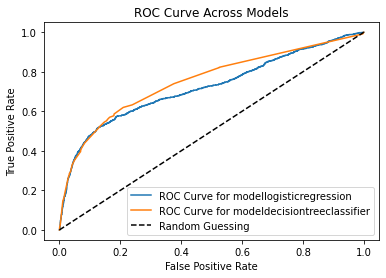

In [117]:
roc_curve_input = {}

for i, j in enumerate(model_metrics):
    if model_metrics[j]['roc_curve']:
        roc_curve_input[j] = model_metrics[j]['roc_curve']

plotROCCurveAcrossModels(roc_curve_input.values(), roc_curve_input.keys())

In [179]:
# classification matrix
# Option 1
from sklearn.metrics import confusion_matrix
y_prediction
y_test.values
conf_mat = confusion_matrix(y_prediction, y_test.values)

#conf_mat

y_pred = pd.Series(y_prediction, name='Predicted')
y_actu = pd.Series(y_test.values, name='Actual')

df_confusion = pd.crosstab(y_actu, y_pred)

conf_mat

array([[4425,  929],
       [ 192,  454]], dtype=int64)

In [116]:
model_metrics['perceptron']['roc_auc_score']

0

In [180]:
np.eye(3)

array([[1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.]])

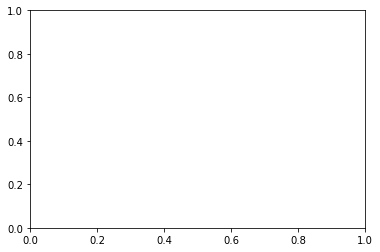

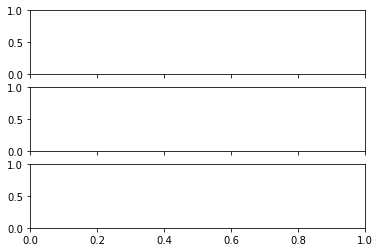

In [209]:
#conf_mat[1, 1] / sum(conf_mat[1, :])
#np.sum(conf_mat)
fig, ax = plt.subplots()

fig, (ax1, ax2, ax3) = plt.subplots(nrows= 3, ncols= 1, sharex = True)

In [222]:
data.columns.str.find('PAY') == 0

array([False, False, False, False, False,  True,  True,  True,  True,
        True,  True, False, False, False, False, False, False,  True,
        True,  True,  True,  True,  True, False])